<a href="https://colab.research.google.com/github/MahdiEsrafili/image_segmentation/blob/dev/cancer_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !wget https://warwick.ac.uk/fac/sci/dcs/research/tia/data/hovernet/consep.zip
# !unzip -q consep.zip -d consep
# import scipy.io
# mat = scipy.io.loadmat('consep/CoNSeP/Train/Labels/train_1.mat')
# np.unique(mat['type_map'])
# img = cv2.imread('consep/CoNSeP/Train/Images/train_1.png')
# img.shape
# plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)
# plt.imshow(mat['type_map'])
# plt.subplot(1,2,2)
# plt.imshow(img)

--2021-02-18 14:17:30--  https://warwick.ac.uk/fac/sci/dcs/research/tia/data/hovernet/consep.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 153334740 (146M) [application/zip]
Saving to: ‘consep.zip’

consep.zip          100%[===================>] 146.23M  15.8MB/s    in 10s     

2021-02-18 14:17:41 (14.0 MB/s) - ‘consep.zip’ saved [153334740/153334740]



In [1]:
!wget https://warwick.ac.uk/fac/sci/dcs/research/tia/data/pannuke/fold_2.zip

--2021-02-22 12:52:53--  https://warwick.ac.uk/fac/sci/dcs/research/tia/data/pannuke/fold_2.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 658842552 (628M) [application/zip]
Saving to: ‘fold_2.zip’

fold_2.zip          100%[===================>] 628.32M  16.4MB/s    in 34s     

2021-02-22 12:53:27 (18.8 MB/s) - ‘fold_2.zip’ saved [658842552/658842552]



In [2]:
!unzip -q fold_2.zip -d panuka/

In [3]:
!git clone https://github.com/MahdiEsrafili/SegLoss.git

Cloning into 'SegLoss'...
remote: Enumerating objects: 334, done.
remote: Total 334 (delta 0), reused 0 (delta 0), pack-reused 334
Receiving objects: 100% (334/334), 371.26 KiB | 1.13 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [128]:
!git clone https://github.com/mateuszbuda/brain-segmentation-pytorch.git
!mv brain-segmentation-pytorch unetbrain

In [7]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-s5n388wb
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-s5n388wb
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=265563 sha256=5357365d2b6877557101684d8893ace7233078360e295b31f1f4a7ffe761d2b0
  Stored in directory: /tmp/pip-ephem-wheel-cache-kt5x02pm/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2
Cloning into 'vision'...
remote: Enumerating objects: 268, done.
remote: Counting objects: 100% (268/268), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 15969 (delta 210), reused 180 (delta 138), pack-reused 15701
Receiving objects: 100% (15969/15969), 16.19 MiB | 13.70 MiB/s, done.
Resolving deltas: 100% (11422/11422), done.


In [ ]:
# !cp drive/MyDrive/torchv.zip ./
# !unzip torchv.zip 
# !cp -a torchv/. ./

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
 import os
 os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader
import torch, torchvision
import torchvision.transforms as T
from tqdm.notebook import trange, tqdm
from PIL import Image

In [8]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from engine import train_one_epoch, evaluate
import utils

In [9]:
masks = np.load('panuka/Fold 2/masks/fold2/masks.npy', mmap_mode='r')
images = np.load('panuka/Fold 2/images/fold2/images.npy', mmap_mode='r')
types = np.load('panuka/Fold 2/images/fold2/types.npy', mmap_mode='r')

In [10]:
channel_types = np.array(['Neoplastic cells', 'Inflammatory', 'Connective/Soft tissue cells', 'Dead Cells', 'Epithelial', 'Background'])

In [11]:
tissue_types, freq = np.unique(types, return_counts=True)
tissue_types, freq

(array(['Adrenal_gland', 'Bile-duct', 'Bladder', 'Breast', 'Cervix',
        'Colon', 'Esophagus', 'HeadNeck', 'Kidney', 'Liver', 'Lung',
        'Ovarian', 'Pancreatic', 'Prostate', 'Skin', 'Stomach', 'Testis',
        'Thyroid', 'Uterus'], dtype='<U13'),
 array([148, 103,  61, 749,  52, 468, 128, 169,  56,  66,  53,  40,  89,
         37,  87,  48,  79,  84,   6]))

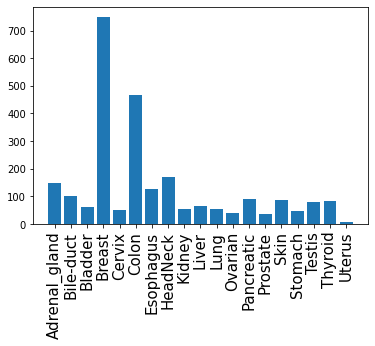

In [ ]:
plt.bar(tissue_types, freq)
plt.xticks(rotation = 90, fontsize=15)
plt.show()

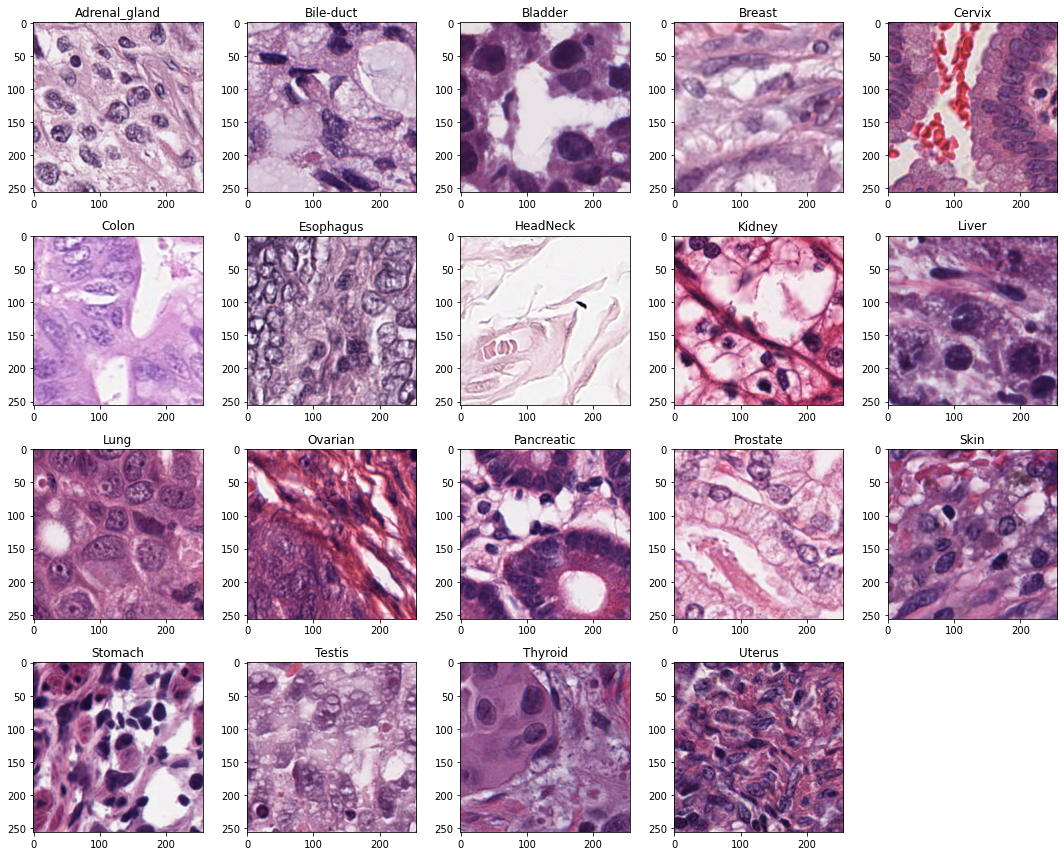

In [ ]:
plt.figure(figsize=(15, 12))
for i, t in enumerate(tissue_types):
  idx = np.where(types==t)[0][np.random.randint(0, 5)]
  plt.subplot(4, 5, i+1)
  plt.imshow(images[idx].astype(np.uint8))
  plt.title(t)

plt.tight_layout()
plt.show()

In [13]:
cell_count_channels = {t:{i:0 for i in range(6)} for t in tissue_types}
pbar = trange(masks.shape[0])
for t in tissue_types:
  ids = np.where(types==t)[0]
  for id in ids:
    for c in range(6):
      counts = np.unique(masks[id, :, :, c]).shape[0]
      cell_count_channels[t][c] += counts
    pbar.update(1)

import pickle
with open('cell_count_channels.pkl', 'wb') as f:
  pickle.dump(cell_count_channels,f)

!cp cell_count_channels.pkl drive/MyDrive/cancer_instance_segmentation/

In [14]:
%pwd

'/content'

In [ ]:
import pickle
!cp drive/MyDrive/cancer_instance_segmentation/cell_count_channels.pkl ./
with open('cell_count_channels.pkl', 'rb') as f:
  cell_count_channels = pickle.load(f)



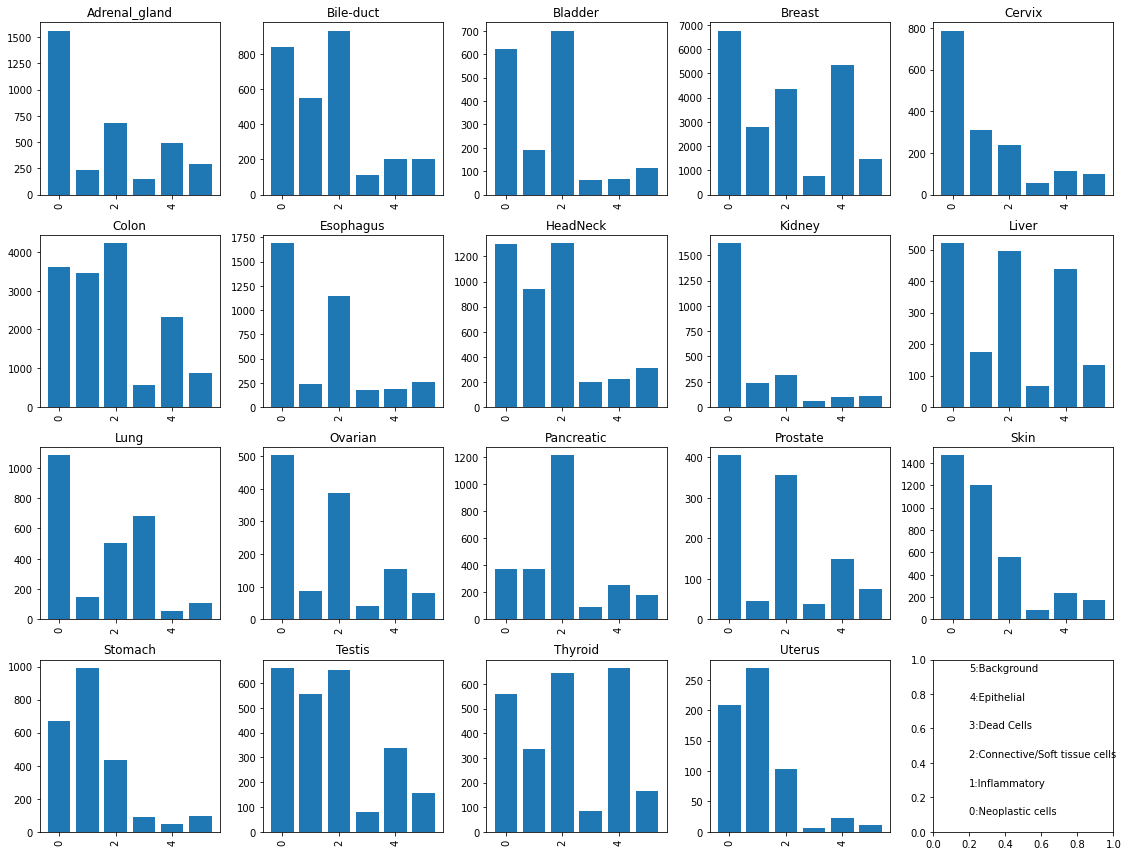

In [ ]:
plt.figure(figsize=(16,12))
for i,t in enumerate(cell_count_channels):
  plt.subplot(4,5, i+1)
  plt.bar(cell_count_channels[t].keys(), cell_count_channels[t].values())
  plt.xticks(rotation=90)
  plt.title(t)

plt.subplot(4,5,20)
for i,c in enumerate(channel_types):
  plt.text(0.2, 0.10+ i/6, f'{i}:{c}')

plt.tight_layout()

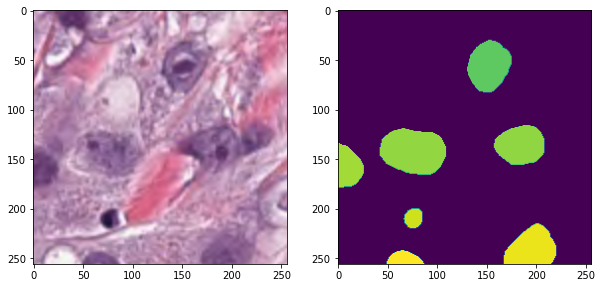

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(images[10].astype(np.uint8))
plt.subplot(1,2,2)
plt.imshow(masks[10,:,:,0].astype(np.uint8))

In [ ]:
np.unique(masks[10,:,:,0])

array([  0., 103., 114., 115., 118., 127., 133., 137.])

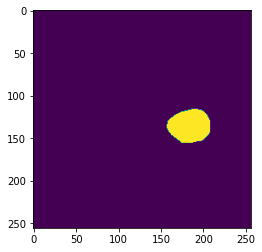

In [ ]:
plt.imshow(masks[10,:,:,0]==114.0)

In [ ]:
class CancerDS(Dataset):
  def __init__(self,indexes, images, masks, types, transform):
    self.indexes = indexes
    self.images = images
    self.masks = masks
    self.types = types
    self.transform = transform

  def __len__(self):
    return self.indexes.shape[0]

  def __getitem__(self, idx):
    image = Image.fromarray(self.images[self.indexes[idx]].astype(np.uint8))
    image = self.transform(image)
    mask = self.masks[idx]
    bboxes, bbox_labels, bbox_areas, masks = self.create_bbox(mask)
    iscrowd = torch.tensor([0 for _ in range(bboxes.shape[0])]) 
    target = {'boxes':bboxes, 'labels':bbox_labels, 'image_id':torch.tensor([idx]),
              'area':bbox_areas, 'iscrowd':iscrowd, 'masks':masks}
    return image, target

  def create_bbox(self, mask):
    channel_types = np.array(['Neoplastic cells', 'Inflammatory', 'Connective/Soft tissue cells', 'Dead Cells', 'Epithelial', 'Background'])
    result = mask.copy()
    bboxes = []
    bbox_labels = []
    bbox_areas = []
    masks = []
    num_channels = result.shape[-1]
    channel_label_map = {0:1, 1:1, 2:2, 3:3, 4:4, 5:0}
    # for channel in range(num_channels-1):
    channel = 0
    unique_objs = np.unique(result[:,:,channel])
    for obj in unique_objs:
      rows, columns = np.where(result[:,:,channel]==obj)
      # if len(rows) == 1:
      #   rows = (rows[0], rows[0]+2)
      # if len(columns) == 1:
      #   columns = (columns[0], columns[0]+2)
      # print(rows.max(), rows.min(), columns.max(), columns.min())
      if (rows.min() == rows.max()) or (columns.min() == columns.max()):
        continue
      if ((rows.min() == 0) and (rows.max() ==255)) or ((columns.min() == 0) and (columns.max() ==255)):
        continue

      bboxes.append([columns.min(), rows.min(), columns.max(), rows.max()])
      bbox_labels.append(channel_label_map[channel])
      area = (rows.max() - rows.min()) * (columns.max() - columns.min())
      bbox_areas.append(area)
      m =(result[:,:,channel] == obj)*result[:,:,channel]
      masks.append(m)
    bboxes = torch.tensor(bboxes, dtype=torch.float32)
    bbox_labels = torch.tensor(bbox_labels, dtype=torch.int64)
    bbox_areas = torch.tensor(bbox_areas, dtype=torch.float32)
    masks = torch.tensor(masks, dtype=torch.int8)
    return bboxes, bbox_labels, bbox_areas, masks


In [15]:
transform = T.Compose([T.ToTensor()])

In [16]:
breast_cell_idx = np.where(types=='Breast')[0]

In [18]:
train_ds = CancerDS(breast_cell_idx, images, masks, types, transform)

In [ ]:
train_ds[2][1]['masks'].shape

torch.Size([6, 256, 256])

In [ ]:
train_ds[2][1]['labels']

tensor([1, 1, 1, 1, 1, 1])

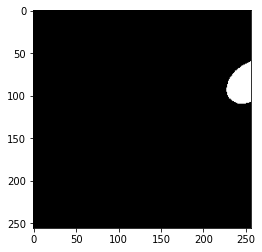

In [ ]:
plt.imshow(train_ds[2][1]['masks'][1], cmap='gray')

In [ ]:
train_ds[2][1]['boxes']

tensor([[215.,   0., 233.,   4.],
        [227.,  60., 255., 109.],
        [ 99.,  59., 137.,  82.],
        [  0.,  88.,  23., 117.],
        [ 77., 103., 101., 125.],
        [  0., 134.,  57., 215.]])

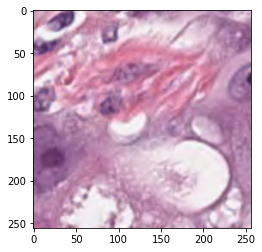

In [ ]:
plt.imshow(train_ds[2][0].permute(1,2,0))

In [ ]:
batch_size = 4
train_loader = DataLoader(train_ds, batch_size, collate_fn=utils.collate_fn)

In [ ]:
def get_model_instance_segmentation(num_classes=2):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(num_classes=2)

# move model to the right device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)

print("That's it!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [  0/188]  eta: 0:04:38  lr: 0.000032  loss: -395.6877 (-395.6877)  loss_classifier: 0.8638 (0.8638)  loss_box_reg: 0.2678 (0.2678)  loss_mask: -397.4772 (-397.4772)  loss_objectness: 0.6281 (0.6281)  loss_rpn_box_reg: 0.0298 (0.0298)  time: 1.4834  data: 0.2706  max mem: 3022
Loss is nan, stopping training
{'loss_classifier': tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(-inf, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_objectness': tensor(0.7756, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0472, device='cuda:0', grad_fn=<DivBackward0>)}


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
%tb

SystemExit: ignored

In [ ]:
with torch.no_grad():
  model.eval()
  img = train_ds[100][0].unsqueeze(0)
  r = model(img)

RuntimeError: ignored

In [ ]:
## lets check semantic segmentaion

In [199]:
class CancerSemantic(Dataset):
  def __init__(self,indexes, images, masks, types, transform, unet=False):
    self.indexes = indexes
    self.images = images
    self.masks = masks
    self.types = types
    self.transform = transform
    self.unet = unet

  def __len__(self):
    return self.indexes.shape[0]

  def __getitem__(self, idx):
    idx = self.indexes[idx]
    image = Image.fromarray(self.images[idx].astype(np.uint8))
    image = self.transform(image)
    mask = self.masks[idx]
    mask = self.create_mask(mask)
    return image, mask

  def create_mask(self, mask):
    channel_types = np.array(['Neoplastic cells', 'Inflammatory', 'Connective/Soft tissue cells', 'Dead Cells', 'Epithelial', 'Background'])
    result = mask.copy()
    num_channels = result.shape[-1]
    channel_label_map = {0:5, 1:1, 2:2, 3:3, 4:4, 5:0}
    if not self.unet:
      masks_out = np.zeros(result.shape[:2])
      for channel in range(num_channels):
        masks_out += np.logical_and(result[:,:,channel], 1) * channel_label_map[channel]  
    else:
      masks_out = np.logical_and(result, 1) * 1
      t = masks_out[:,:,0].copy()
      masks_out[:,:,0] = masks_out[:,:,5].copy()
      masks_out[:,:,5] = t 
      masks_out = masks_out.transpose(2,0,1)
    masks_out = torch.tensor(masks_out, dtype=torch.int8)
    return masks_out


In [155]:
cancer_semantic_ds = CancerSemantic(breast_cell_idx, images, masks, types, transform)

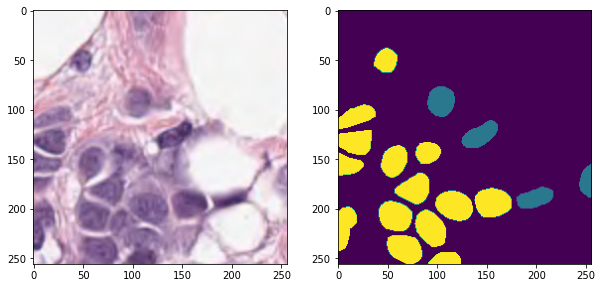

In [92]:
i,m = cancer_semantic_ds[90]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(i.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(m)


In [93]:
len(cancer_semantic_ds)

749

In [94]:
train_dataset, test_dataset = torch.utils.data.random_split(cancer_semantic_ds, [500, 249])

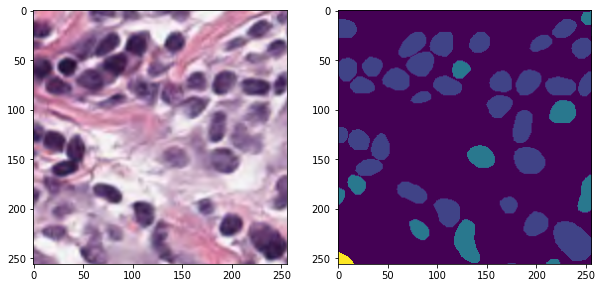

In [95]:
i,m = test_dataset[40]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(i.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(m)


In [96]:
batch_size = 4
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [97]:
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True)
model.classifier = torchvision.models.segmentation.deeplabv3.DeepLabHead(2048, 6)

In [211]:
# unet model. comment or uncomment to select deepLab or unet
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=6, init_features=32, pretrained=False)

cancer_semantic_ds_unet = CancerSemantic(breast_cell_idx, images, masks, types, transform, unet=True)
train_dataset, test_dataset = torch.utils.data.random_split(cancer_semantic_ds_unet, [500, 249])
batch_size = 4
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [212]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [213]:
model = model.train().to(device)

In [214]:
def train(model, optimizer, criterion, lr_scheduler, dataloaders, num_epochs=10):
  model.train()
  loss_history = list()
  num_epochs=10
  for epoch in range(num_epochs):
    pbar = tqdm(dataloaders['train'])
    epoch_losses = np.array([])
    for (images, masks) in pbar:
      images = images.to(device, dtype=torch.float)
      masks = masks.to(device, dtype=torch.long)
      optimizer.zero_grad()
      out = model(images)
      loss = criterion(out, masks) # when using deeplab, output is dict, unet is tensor
      loss.backward()
      optimizer.step()
      epoch_losses = np.append(epoch_losses, loss.item())
      pbar.set_description(f'epoch {epoch+1}/{num_epochs},\
                            loss= {epoch_losses.mean():.4f}')
    loss_history.append(epoch_losses.mean())
    lr_scheduler.step()
  return model, loss_history
      

In [215]:
from SegLoss.losses_pytorch import lovasz_loss
from unetbrain.loss import DiceLoss

In [216]:
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = DiceLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

In [217]:
dataloaders = {'train': train_loader,
               'test': test_loader}

In [218]:
model, loss_history = train(model, optimizer, criterion, lr_scheduler, dataloaders, num_epochs=15)

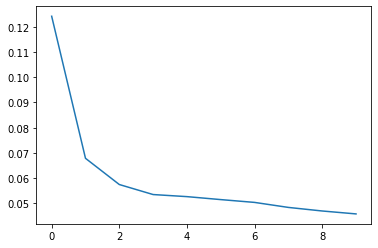

In [219]:
plt.plot(loss_history)

In [220]:
with open('semantic_segmentation.pt', 'wb') as f:
  torch.save(model, f)

!cp semantic_segmentation.pt drive/MyDrive/cancer_instance_segmentation/

In [ ]:
!cp drive/MyDrive/cancer_instance_segmentation/semantic_segmentation.pt ./
with open('semantic_segmentation.pt', 'rb') as f:
  model = torch.load(f, map_location=torch.device('cpu'))



In [223]:
def test(test_loader, model):
  with torch.no_grad():
    model.eval()
    # model = model.to('cpu')
    test_losses = []
    preds = []
    for img,mask in test_loader:
      img = img.to(device, dtype=torch.float)
      mask = mask.to(device, dtype=torch.long)
      pred = model(img)
      loss = criterion(pred, mask)
      test_losses.append(loss.item())
      preds.append(pred.cpu())

    return preds, test_losses


In [224]:
preds, test_losses = test(test_loader, model)

In [225]:
sum(test_losses) / len(test_losses)

0.057246465531606526

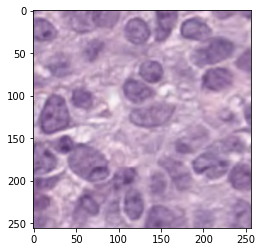

In [233]:
plt.imshow(test_dataset[2][0].permute(1,2,0))

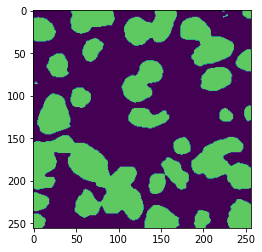

In [230]:
plt.imshow(preds[0][2].argmax(dim=0))

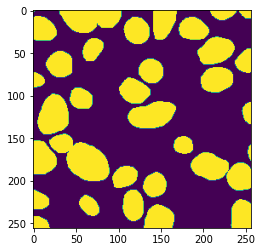

In [232]:
plt.imshow(test_dataset[2][1].argmax(dim=0))